In [21]:
from os import listdir
from sklearn.model_selection import train_test_split
from glob import glob
from tensorflow import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

import pandas as pd
import numpy as np
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt

In [22]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Índice

1. Creación del dataframe
2. Creación de los subconjuntos de datos
3. Conclusiones
4. Referencias

# 1. Creación del dataframe
En primer lugar, se va a crear un dataframe que facilite posteriormente, la carga de las imágenes para el entrenamiento. Para ello, se busca crear un dataframe con 3 columnas, **patiend_id**, **path** de la imagen y la **label** de la muesta

In [23]:
base_path = 'IDC_regular_ps50_idx5/'

In [24]:
def preprocess_data(base_path):
    data = []
    
    folder = listdir(base_path)
    for n in range(len(folder)):
        patient_id = folder[n]
        patient_path = base_path + patient_id 
        for c in [0,1]:
            class_path = patient_path + "/" + str(c) + "/"
            subfiles = listdir(class_path)
            for m in range(len(subfiles)):
                image_path = subfiles[m]
                
                row = {}
                row["patient_id"] = patient_id
                row["path"] = class_path + image_path
                row["label"] = c

                data.append(row)
    df = pd.DataFrame(data)
    return df    

In [25]:
data = preprocess_data(base_path)
data.head(5)

,patient_id,path,label
0,10253,IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001...,0
1,10253,IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001...,0
2,10253,IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001...,0
3,10253,IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001...,0
4,10253,IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001...,0


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 277524 entries, 0 to 277523
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   patient_id  277524 non-null  object
 1   path        277524 non-null  object
 2   label       277524 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 6.4+ MB


# 2. Creación de los subconjuntos de datos
Posteriormente, se procede a crear 3 subconjuntos de datos: **training**, **validation** y **test**. El objetivo es entrenar los distintos modelos a desarrollar con el conjunto training, probar el rendimiento del modelo y ajustar los hiperparámetros y finalmente, evaluar el rendimiento del modelo con el conjunto test, una vez que se han ajustado los hiperparámetros. 

Por tanto, la división final es: 30% para el conjunto de test. Dentro de ese 30%, la mitad para validation y la otra mitad para test.

In [27]:
X = data.drop('label', axis=1)
y = data['label']

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Split the test set further into test and validation sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)
print("Validation Data Shape:", X_val.shape)

Training Data Shape: (194266, 2)
Testing Data Shape: (41629, 2)
Validation Data Shape: (41629, 2)


In [28]:
X_train["label"] = y_train
X_test["label"] = y_test
X_val["label"] = y_val

Se crean los 3 archivos **csv** para poder cargar los datos en un futuro. De esta forma, se podrá comporar los modelos al evaluar sus rendimientos en el mismo subconjunto de datos.

In [29]:
X_train.to_csv("train_data.csv", index=False)
X_test.to_csv("test_data.csv", index=False)
X_val.to_csv("val_data.csv", index=False)

Ahora se estudiará la distribución de los subconjuntos de datos.

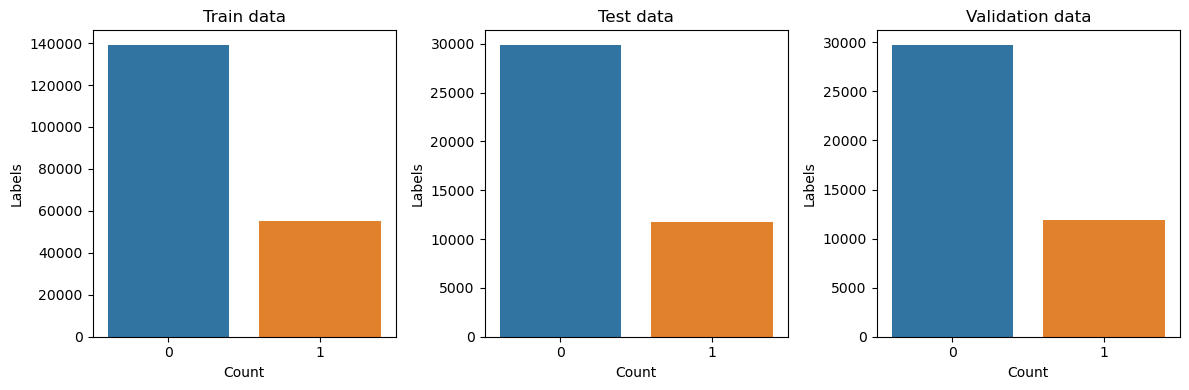

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

df_y_train = pd.DataFrame()
df_y_train["Train"] = y_train

df_y_test = pd.DataFrame()
df_y_test["Test"] = y_test

df_y_val = pd.DataFrame()
df_y_val["Val"] = y_val


sns.countplot(data=df_y_train, x='Train', ax=axs[0])
sns.countplot(data=df_y_test, x='Test', ax=axs[1])
sns.countplot(data=df_y_val, x='Val', ax=axs[2])

axs[0].set_title('Train data')
axs[0].set_xlabel('Count')
axs[0].set_ylabel('Labels')

axs[1].set_title('Test data')
axs[1].set_xlabel('Count')
axs[1].set_ylabel('Labels')

axs[2].set_title('Validation data')
axs[2].set_xlabel('Count')
axs[2].set_ylabel('Labels')

plt.tight_layout()

plt.show()

# 3. Conclusiones

* Como se puede observar, los 3 subconjuntos de datos están desbalanceados en la misma proporción (división estratificada).
* No se va a optar por técnicas como **oversampling** o **subsampling** para igualar las clases, pues este tipo de técnicas ya han sido usadas en estudios anteriores [1]. Nuestro objetivo es aplicar otro tipo de técnica como la **ponderación de las clases**, para evaluar el rendimiento de los modelos con dicha técnica en comparación a entrenar el modelo con un conjunto de datos equilibrado.

# 4. Referencias
[1] F. Perdigón Romero, A. Tang, S. Kadoury, *MULTI-LEVEL BATCH NORMALIZATION IN DEEP NETWORKS FOR INVASIVE DUCTAL
CARCINOMA CELL DISCRIMINATION IN HISTOPATHOLOGY IMAGES*